# 数値積分-integrate

SciPyの`integrate`モジュールは、常微分方程式(ODE)の数値積分を含むいくつかの数値積分アルゴリズムを提供します。

In [17]:
from matplotlib import pyplot as plt
import helper.matplotlib
import numpy as np
from scipy import integrate
from scipy.integrate import odeint

## 球の体積

数値積分は定積分の数値解法であり、例えば数値積分を使用して特定の形状の面積を計算することができます。まず、半径1の半円の面積を計算する方法を考えてみましょう。円の面積公式によると、その面積は$\pi/2$に等しいはずです。単位半円の曲線方程式は$y=\sqrt{1-x^2}$で、以下の`half_circle()`で計算できます：

In [18]:
def half_circle(x):
    return (1 - x**2) ** 0.5

最も単純な数値積分アルゴリズムは、積分する面積を多くの小さな長方形に分割し、これらの長方形の面積の合計を計算することです。以下では、X軸上の-1から1の区間を10000等分し、面積の合計を計算します：

In [19]:
N = 10000
x = np.linspace(-1, 1, N)
dx = x[1] - x[0]
y = half_circle(x)
2 * dx * np.sum(y)  # 面積の2倍

3.1415893269307373

NumPyの`trapz()`を使用して、半円上の各点で構成される多角形の面積を計算することもできます。`trapz()`は、`(x, y)`を頂点座標とする折れ線とX軸で囲まれた面積を計算します：

In [20]:
np.trapz(y, x) * 2  # 面積の2倍

3.1415893269315975

`integrate.quad()`を使用して数値積分を行うと、非常に正確な結果が得られます：

In [21]:
from scipy import integrate

pi_half, err = integrate.quad(half_circle, -1, 1)
pi_half * 2

3.1415926535897967

多重定積分を計算するには、`quad()`を複数回呼び出すことができます。呼び出しを便利にするために、`integrate`モジュールは二重定積分を行う`dblquad()`と三重定積分を行う`tplquad()`を提供しています。以下では、単位半球の体積を計算する例を示し、`dblquad()`の使用方法を説明します。

単位半球面上の点$(x,y,z)$は方程式$x^2 + y^2 + z^2 = 1$を満たすため、以下の`half_sphere()`はX-Y軸座標から球面上の点のZ軸座標値を計算できます：

In [22]:
def half_sphere(x, y):
    return (1 - x**2 - y**2) ** 0.5

X-Y軸平面とこの球体の交線は単位円であるため、二重積分の計算区間はこの単位円になります。つまり、X軸については-1から1まで積分し、Y軸については`-half_circle(x)`から`half_circle(x)`まで積分します。したがって、半球体積の二重積分公式は次のようになります：

$$\int_{-1}^{1}{\int_{-\sqrt{1-x^2}}^{\sqrt{1-x^2}}{\sqrt{1-x^2-y^2} dy} dx}$$

以下のプログラムは`dblquad()`を使用して半球体積を計算します：

In [23]:
volume, error = integrate.dblquad(
    half_sphere, -1, 1, lambda x: -half_circle(x), lambda x: half_circle(x)
)

print(volume, error, np.pi * 4 / 3 / 2)

2.0943951023931984 1.0002354500215915e-09 2.0943951023931953


`dblquad()`の呼び出しパラメータは次のとおりです：`dblquad(func2d, a, b, gfun, hfun)`。ここで、`func2d`は二重積分を行う関数で、2つのパラメータを持ちます。仮にそれらを`x`と`y`とします。`a`と`b`パラメータは、被積分関数の最初の変数`x`の積分区間を指定し、`gfun`と`hfun`パラメータは2番目の変数`y`の積分区間を指定します。`gfun`と`hfun`は関数であり、変数`x`から変数`y`の積分区間を計算します。これにより、X-Y平面上の任意の区間で`func2d`を積分することができます。

次のグラフは半球体積の積分図です。図からわかるように、X軸の積分区間は-1から1で、X軸上の点x0に対して、Y軸の積分を行うことで図中の濃い色の垂直断面の面積を計算できます。したがって、Y軸の積分区間は図中の点線で示されています。

![半球体二重積分図](images/scipy_integrate.png)

## 常微分方程式の解法

`integrate`モジュールは、常微分方程式の積分を行う関数`odeint()`も提供しています。以下では、それを使ってローレンツアトラクタの軌跡を計算する方法を見ていきます。ローレンツアトラクタは以下の3つの微分方程式で定義されます：

$$\frac{dx}{dt} = \sigma \cdot (y - x), \ \ 
\frac{dy}{dt} = x \cdot (\rho - z) - y, \ \ 
\frac{dz}{dt} = xy - \beta z$$ 

これらの方程式は、3次元空間内の各座標点における速度ベクトルを定義します。ある座標から速度ベクトルに沿って積分を行うことで、質量のない点がこの空間内でどのように動くかを計算できます。ここで、$\sigma$、$\rho$、$\beta$は3つの定数であり、異なるパラメータを使うことで異なる運動軌跡：$x(t)$、$y(t)$、$z(t)$を計算できます。特定のパラメータ値では、軌跡にカオス現象が現れます。つまり、初期値のわずかな違いが運動軌跡に大きな影響を与えます。以下はローレンツアトラクタの軌跡を計算するプログラムです。

❶まず、関数`lorenz()`を定義します。この関数の役割は、ある座標点における各方向の微分値を計算することです。これはローレンツアトラクタの公式に基づいて直接計算できます。

❷❸異なる初期値を使って`odeint()`を2回呼び出し、微分方程式を解きます。`odeint()`には多くのパラメータがありますが、ここで使用する5つのパラメータは以下の通りです：

1. `lorenz`：ある位置における各方向の速度を計算する関数です。
2. `(0.0, 1.0, 0.0)`：位置の初期値で、常微分方程式を解くために必要な各変数の初期値です。
3. `t`：時間の配列で、`odeint()`はこの配列内の各時間点に対して解を求め、すべての時間点におけるシステムの状態を計算します。
4. `args`：これらのパラメータは`lorenz()`に直接渡され、積分プロセス全体で定数として扱われます。
5. `tfirst`：`True`の場合、微分値を計算する関数`lorenz()`の最初の引数は時刻`t`、2番目の引数は時刻`t`におけるシステムの状態です。

次のグラフは`odeint()`によって得られた軌跡を示しています。結果からわかるように、初期値が0.01しか違わなくても、2つの運動軌跡は完全に異なります。

```{seealso}
http://bzhang.lamost.org/website/archives/lorenz_attactor

ローレンツアトラクタの詳細な説明。
```

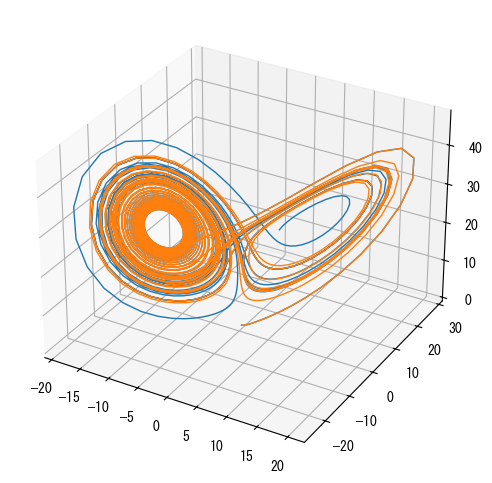

In [26]:
from scipy.integrate import odeint
import numpy as np


def lorenz(t, w, p, r, b):  # ❶
    # 位置ベクトルwと3つのパラメータp, r, bを与えて、
    # dx/dt, dy/dt, dz/dtの値を計算する
    x, y, z = w.tolist()
    # ローレンツの計算式に直接対応
    return p * (y - x), x * (r - z) - y, x * y - b * z


t = np.arange(0, 30, 0.02)  # 時間点を作成
# odeを呼び出してlorenzを解く、2つの異なる初期値を使用
track1 = odeint(lorenz, (0.0, 1.00, 0.0), t, args=(10.0, 28.0, 3.0), tfirst=True)  # ❷
track2 = odeint(lorenz, (0.0, 1.01, 0.0), t, args=(10.0, 28.0, 3.0), tfirst=True)  # ❸

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.plot(track1[:, 0], track1[:, 1], track1[:, 2], lw=1)
ax.plot(track2[:, 0], track2[:, 1], track2[:, 2], lw=1);

`odeint()`を使って微分方程式を解くには、システムの状態を出力する時間点を指定する必要がありますが、新しい関数`solve_ivp()`では、積分アルゴリズムが自動的に状態を保存する時間点を決定できます。

以下のプログラムは`solve_ivp()`を使ってローレンツアトラクタを積分します。最初の3つのパラメータは、微分値を計算する関数、積分する時間区間、およびシステムの初期状態です。`method`パラメータは積分アルゴリズムを指定し、`RK45`は古典的なルンゲ・クッタ法です。
`solve_ivp()`は積分結果を表す`OdeResult`オブジェクトを返します。その属性`t`と`y`は、自動的に決定された時間点と各時間点におけるシステムの状態です。`dense_output`パラメータが`True`の場合、その`sol`属性は`OdeSolution`オブジェクトであり、このオブジェクトは補間アルゴリズムを使って任意の時間点におけるシステムの状態を計算できます。

以下の結果からわかるように、`solve_ivp()`は349個の時間点を計算し、この`349`個の時間点は時間区間を348個の区間に分割します。

In [27]:
from scipy.integrate import solve_ivp
from functools import partial

r = solve_ivp(
    lorenz, (0, 30), (0, 1, 0), args=(10, 28, 3), method="RK45", dense_output=True
)
print("segments = {}, t length={}".format(r.sol.n_segments, len(r.t)))

segments = 348, t length=349


`OdeSolution`オブジェクトを直接呼び出すことで、任意の時間点におけるシステムの状態を計算できます。以下では、積分区間を20000個の時間点に等分割し、各時間点における補間結果を計算します。次のグラフでは、滑らかな曲線が補間結果で、丸い点は`solve_ivp()`によって積分されたシステムの状態です。

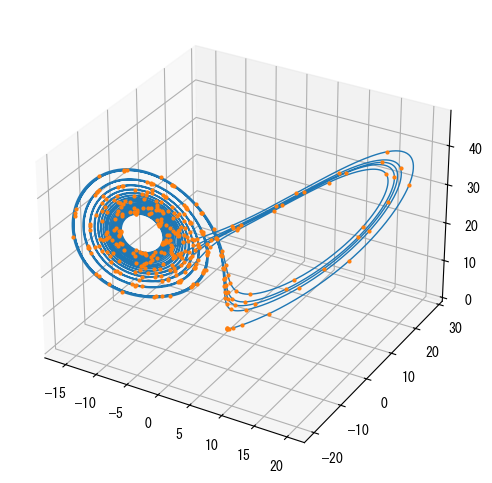

In [29]:
t = np.linspace(0, 30, 20000)
x, y, z = r.sol(t)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection="3d")
ax.plot(x, y, z, lw=1)
x2, y2, z2 = r.y
ax.plot(x2, y2, z2, "o", ms=2);

## 質量-ばね-ダンパーシステム

このセクションでは、常微分方程式ソルバーを使って次のグラフに示すようなばねシステムをシミュレートし、PIDコントローラーを使ってスライダーの位置を制御する方法を紹介します。このシステムの微分方程式は以下の通りです：

$$m \ddot{x} + b \dot{x} + k x = F$$

ここで、$x$はスライダーの変位、$\dot{x}$はスライダーの速度（$x$の時間に関する1次微分）、$\ddot{x}$はスライダーの加速度（$x$の時間に関する2次微分）です。$m$はスライダーの質量、$b$はダンパーの係数、$k$はばねの係数、$F$はスライダーに加わる外部制御力です。これは2次微分方程式であり、`odeint()`を使って解くためには、以下のように1次微分方程式系に変換する必要があります：

$$
\begin{align*}
\dot{x} &= u \\ 
\dot{u} &= (F - k x - b u)/m
\end{align*}
$$

ここで、$x$はスライダーの変位、$u$はスライダーの速度です。これら2つの変数がシステムの状態を構成します。これらの時間に関する微分は、これらの方程式から直接計算できます。

![質量-ばね-ダンパーシステム](images/mass_spring_damper.png)

以下では、`MassSpringDamper`クラスを使って質量-ばね-ダンパーシステムを定義します。このクラスは、システムのパラメータ`M`、`k`、`b`、および`force`などをオブジェクト内にカプセル化し、その`diff()`メソッドは変位と速度の微分を計算します。

In [30]:
class MassSpringDamper:
    def __init__(self, m, k, b, force=0):
        self.m, self.k, self.b = m, k, b
        self.force = force

    def diff(self, t, status):
        x, u = status
        dx = u
        du = (self.force - self.k * x - self.b * u) / self.m
        return [dx, du]

以下では、`odeint()`を使ってこのシステムを解きます。スライダーの初期変位と初期速度はどちらも0で、外部制御力は常に1です。次のグラフに示すように、システムは約2秒後に変位0.05で停止します。

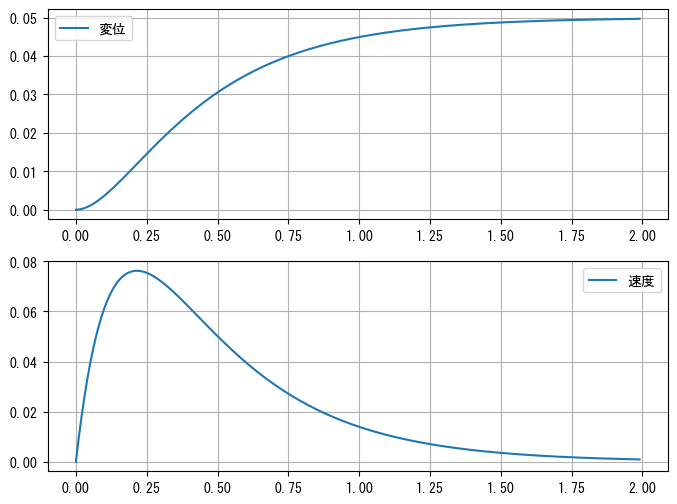

In [31]:
m, k, b, force = 1.0, 20.0, 10.0, 1.0
open_system = MassSpringDamper(m, k, b, force)
init_status = 0.0, 0.0
t = np.arange(0, 2, 0.01)
result = odeint(open_system.diff, init_status, t, tfirst=True)
# %hide
fig, axes = plt.subplots(2, 1, figsize=(8, 6))
axes[0].plot(t, result[:, 0], label="変位")
axes[1].plot(t, result[:, 1], label="速度")
for ax in axes:
    ax.legend()
    ax.grid()

外力$F$を制御することで、スライダーをより迅速に変位1.0で停止させたいと考えています。次のグラフは、制御理論で最も一般的に使用されるPIDコントローラーのシステム図です：

![PID制御システム](images/PID-system.svg)

上のグラフでは、Setpointが制御の目標状態で、この例ではスライダーの目標変位です。Processは制御対象のシステムで、その出力Outputは制御システム全体の出力で、この例ではスライダーの実際の変位です。両者の誤差ErrorがPIDコントローラーの入力となります。PIDコントローラーは3つの独立した部分で構成されます：

* P：比例項で、出力は誤差に比例します。
* I：積分項で、出力は誤差の積分に比例します。
* D：微分項で、出力は誤差の微分に比例します。

これら3つの項の合計がPIDコントローラーの出力となり、この例ではコントローラーの出力はスライダーに加わる外力$F$です。システム図では、積分と微分の記号を使って積分項と微分項を表しています。

以下はPIDコントローラーのプログラムです。クラス`PIDControl`を使って`kp`、`ki`、`kd`などのパラメータと目標変位`x_ref`をカプセル化します。`control_force()`メソッドは制御力を計算するために使用され、`status`は変位、速度、およびPIDコントローラーの誤差入力の積分を含む3つの状態の配列です。出力される制御力は、誤差、誤差の積分、および誤差の微分にそれぞれ対応するゲイン係数を乗じて合計したものです。制御システムの構成から、誤差の微分は速度に-1を乗じたものです。

In [32]:
class PIDControl:
    def __init__(self, kp, ki, kd, x_ref):
        self.kp, self.ki, self.kd = kp, ki, kd
        self.x_ref = x_ref

    def control_force(self, status):
        x, u, eint = status
        self.err = self.x_ref - x
        force = self.kp * self.err + self.ki * eint + self.kd * (-u)
        return force

以下の`System`クラスは、`MassSpringDamper`と`PIDControl`をカプセル化し、その`diff()`メソッドは変位、速度、および制御誤差の積分の3つの状態の微分を計算します。

In [33]:
class System:
    def __init__(self, m, k, b, kp, ki, kd, x_ref):
        self.target = MassSpringDamper(m, k, b)
        self.pid = PIDControl(kp, ki, kd, x_ref)

    def diff(self, t, status):
        x, u, eint = status
        self.target.force = self.pid.control_force(status)
        dx, du = self.target.diff(t, [x, u])
        return dx, du, self.pid.err

以下では、`odeint()`を使って質量-ばね-ダンパーのPID制御システムをシミュレートします。各時間点における状態を計算した後、その状態を`system.pid.control_force()`に渡して制御システムの出力力を計算します。

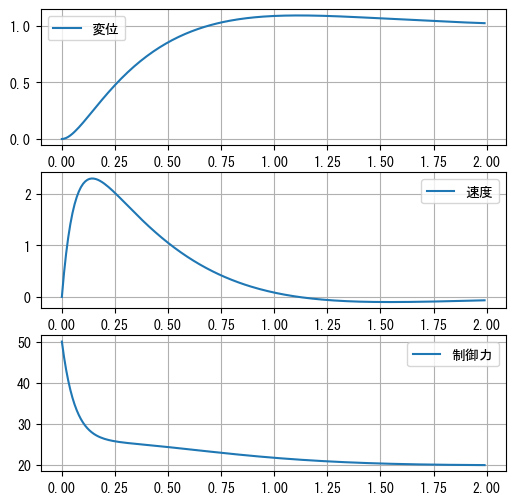

In [35]:
system = System(m=m, k=k, b=b, kp=50, ki=100, kd=10, x_ref=1)
init_status = 0.0, 0.0, 0.0
dt = 0.01
t = np.arange(0, 2, dt)
res = odeint(system.diff, init_status, t, tfirst=True)

x, v, eint = res.T
force = system.pid.control_force(res.T)


def plot_result(t, x, v, force):
    fig, axes = plt.subplots(3, 1, figsize=(6, 6))
    for ax in axes:
        ax.grid(True)
    axes[0].plot(t, x, label="変位")
    axes[0].legend(loc="best")
    axes[1].plot(t, v, label="速度")
    axes[1].legend(loc="best")
    axes[2].plot(t, force, label="制御力")
    axes[2].legend(loc="best")


plot_result(t, x, v, force)

PIDコントローラーの3つのパラメータを調整することで、最適な制御効果を得ることができます。前述の`optimize`モジュールの関数を使って、最適なPIDパラメータを自動的に見つけることができます。最適化関数を使用するためには、制御結果を評価する関数を記述する必要があります。目標はスライダーをできるだけ早く変位1.0で停止させることなので、最初の2秒間のスライダーの変位と目標変位の差の絶対値の合計を制御結果の評価として使用できます。この値が小さいほど、制御が良好であることを示します。

In [36]:
%%time
from scipy import optimize


def pid_control_system(kp, ki, kd, dt, m=1.0, k=20.0, b=10.0, tend=2):
    system = System(m=m, k=k, b=b, kp=kp, ki=ki, kd=kd, x_ref=1)
    init_status = 0.0, 0.0, 0.0
    t = np.arange(0, tend, dt)
    res = odeint(system.diff, init_status, t, tfirst=True)
    force = system.pid.control_force(res.T)
    return t, res.T, force


def eval_func(k):
    kp, ki, kd = k
    t, (x, v, eint), force = pid_control_system(kp, ki, kd, 0.01)
    return np.sum((x - 1.0) ** 2)


kwargs = {"method": "L-BFGS-B", "bounds": [(10, 1000), (10, 1000), (1, 200)]}

opt_k = optimize.basinhopping(
    eval_func, (10, 10, 10), niter=10, minimizer_kwargs=kwargs
)
print(opt_k.x, opt_k.fun)

[980.73541322 353.27164322  21.22849394] 3.6872626223237104
CPU times: total: 5.47 s
Wall time: 5.59 s


以下に、最適化器の出力をPIDのパラメータとしてシステムをシミュレーションした結果を示します。制御開始後0.5秒で、スライダーがほぼ1.0の位置に安定していることが確認できます。これは次のグラフに示されています。

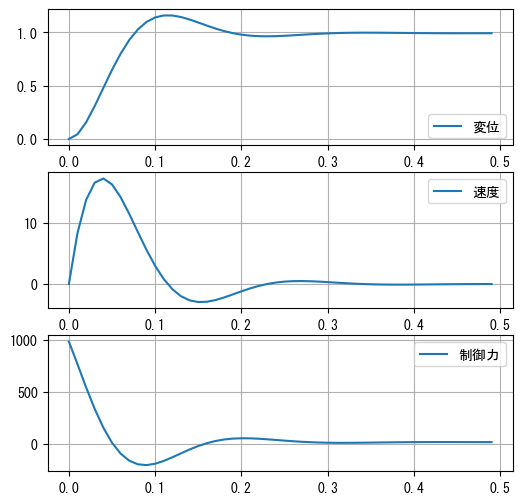

In [37]:
t, (x, v, eint), force = pid_control_system(*opt_k.x, dt=0.01, tend=0.5)
plot_result(t, x, v, force)

## 懸垂線のシミュレーション

ニュートン力学の運動方程式を用いて懸垂線をシミュレーションするために、懸垂線を複数のバネで接続された質点系と見なすことができます。各質点は重力と左右のバネ力を受けます。質点が運動する際には、速度に比例する抵抗も受けます。懸垂線の両端の質点を静止させるために、これらの質点の力を計算しないようにし、したがってこれらの質点の加速度は常に0となります。各質点にはX方向とY方向の速度と加速度の4つの状態があり、$N$個の質点からなるシステムでは、合計$4 \times N$個の状態があります。

以下の`diff_status(t, status)`は、状態`status`の微分を計算し、その後`solve_ivp()`を使用してこのシステムを積分し、異なる時刻でのシステムの状態を計算します。時間が十分に長くなると、抵抗の作用により、各質点は最終的に平衡位置に達し、その効果は次のグラフに示されています。

a= 0.337 length= 1.377 solve length= 1.410


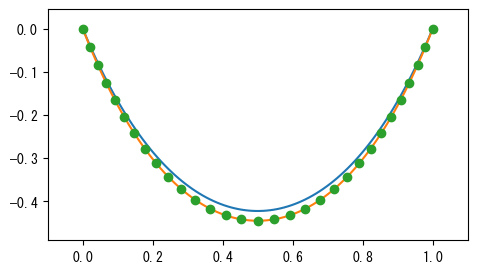

In [38]:
import math


def catenary(x, a):
    return a * np.cosh((x - 0.5) / a) - a * np.cosh((-0.5) / a)


def catenary_length(a):
    def fs(x):
        return (math.sinh((x - 0.5) / a) ** 2 + 1) ** 0.5

    return integrate.quad(fs, 0, 1)[0]


a = 0.35
length = catenary_length(a)
N = 31
dump = 0.2  # 減衰係数
k = 100.0  # バネ定数
l = length / (N - 1)  # バネの自然長
g = 0.01  # 重力加速度

x0 = np.linspace(0, 1, N)
y0 = np.zeros_like(x0)
vx0 = np.zeros_like(x0)
vy0 = np.zeros_like(x0)


def diff_status(t, status):
    x, y, vx, vy = status.reshape(4, -1)
    dvx = np.zeros_like(x)
    dvy = np.zeros_like(x)
    dx = vx
    dy = vy

    s = np.s_[1:-1]

    l1 = np.sqrt((x[s] - x[:-2]) ** 2 + (y[s] - y[:-2]) ** 2)
    l2 = np.sqrt((x[s] - x[2:]) ** 2 + (y[s] - y[2:]) ** 2)
    dl1 = (l1 - l) / l1
    dl2 = (l2 - l) / l2
    dvx[s] = -vx[s] * dump - (x[s] - x[:-2]) * k * dl1 - (x[s] - x[2:]) * k * dl2
    dvy[s] = -vy[s] * dump - (y[s] - y[:-2]) * k * dl1 - (y[s] - y[2:]) * k * dl2 + g
    return np.r_[dx, dy, dvx, dvy]


status0 = np.r_[x0, y0, vx0, vy0]

t = np.linspace(0, 50, 100)
r = integrate.solve_ivp(diff_status, (0, 50), status0)
x, y, vx, vy = r.y[:, -1].reshape(4, -1)

r, e = optimize.curve_fit(catenary, x, -y, [1])
print(
    "a={:6.3f} length={:6.3f} solve length={:6.3f}".format(
        r[0], length, catenary_length(r[0])
    )
)

fig = plt.figure(figsize=(7, 3))
x2 = np.linspace(0, 1, 100)
plt.plot(x2, catenary(x2, a))
plt.plot(x2, catenary(x2, r[0]))
plt.plot(x, -y, "o")
plt.margins(0.1)
plt.subplots_adjust(left=0.3)

上のグラフでは、円点は各質点の最終位置を示し、赤い曲線は懸垂線の方程式を使用して質点の位置をフィットした最適な懸垂線であり、青い曲線はバネが自然長の状態での懸垂線です。最終状態を自然長の懸垂線に近づけるためには、できるだけ大きなバネ定数とできるだけ小さな重力加速度が必要です。これにより、各バネが自然長に近づくことが保証されます。読者は前の係数を変更して、最終状態を青い曲線にできるだけ近づけるように試してみてください。

本書では、懸垂線のアニメーションシミュレーションプログラムを提供しており、コントロールを使用して各パラメータを変更し、それらが運動に与える影響をリアルタイムで観察できます。このプログラムは`solve_ivp()`内部で呼び出される積分アルゴリズム`integrate.RK45`を使用して実装されています。その`step()`メソッドを使用して時間を少し進め、システムの状態を段階的に計算することができます。興味のある読者は、プログラムコードを読んでみてください。

### 懸垂線の境界値問題

懸垂線の曲線関数は、以下の2つの微分方程式を解くことで得られます。ここで$(x, y)$は懸垂線上の点の座標であり、$a$は懸垂線の形状を決定するパラメータです。

$$
\begin{align}
\frac {dy}{dx}&=\frac {s}{a}
\\
\frac {ds}{dx}&=\sqrt {1+\left({\dfrac {dy}{dx}}\right)^{2}}
\end{align}
$$

懸垂線の両端の高さは固定されているため、これは境界値問題であり、`solve_bvp()`を使用してこれを解くことができます。

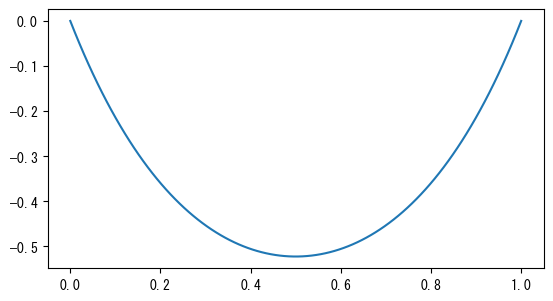

In [41]:
a = 0.3

tmp = []


def catenary_func(x, variables):
    tmp.append(variables.copy())
    y, s = variables
    dy = s / a
    ds = (1 + dy**2) ** 0.5
    return np.vstack((dy, ds))


def bc_func(vars_a, vars_b):
    ya, sa = vars_a
    yb, sb = vars_b
    return [ya - 0, yb - 0]


x = np.linspace(0, 1, 10)
variables = np.zeros((2, len(x)))
res = integrate.solve_bvp(catenary_func, bc_func, x, variables)

x2 = np.linspace(0, 1, 100)
y2, s2 = res.sol(x2)

fig, ax = plt.subplots()
ax.set_aspect(True)
ax.plot(x2, y2);